In [42]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np

from astropy.table import Table
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.samp import SAMPIntegratedClient
from astropy.io import fits
from astropy.wcs import WCS
from astropy.stats import sigma_clipped_stats
import astropy.visualization as ap_vis

from astroquery.vizier import Vizier
from astroquery.xmatch import XMatch
from astroquery.simbad import Simbad
import ipyaladin as ipyal
import pyvo
from pyvo import tap as tap

import warnings 
warnings.filterwarnings('ignore')

import sys


In [240]:
#setup vizier
vizier_tap_link='http://TAPVizieR.u-strasbg.fr/TAPVizieR/tap/'
tap_vizier=tap.TAPService(vizier_tap_link)


#single observations in XMMOM
single=0
if(single>0):
    ricerca_single='''
    SELECT top 20
    XMMOM, ID, RAJ2000, DEJ2000, ePos, Nobs,
    UVW2mAB, UVM2mAB, UVW1mAB, UmAB, BmAB, VmAB,
    e_UVW2mAB, e_UVM2mAB, e_UVW1mAB, e_UmAB, e_BmAB, e_VmAB
    FROM \"II/370/xmmom5s\" 
    WHERE nobs=1
    '''
    xmmom_single=tap_vizier.search(query=ricerca_single).table

#multiple
multi=0
if(multi>0):
    ricerca_multi='''
    SELECT top 5000
    XMMOM, ID, RAJ2000, DEJ2000, ePos, Nobs,
    UVW2mAB, UVM2mAB, UVW1mAB, UmAB, BmAB, VmAB,
    e_UVW2mAB, e_UVM2mAB, e_UVW1mAB, e_UmAB, e_BmAB, e_VmAB
    FROM \"II/370/xmmom5s\" 
    WHERE nobs>1
    '''
    xmmom_=tap_vizier.search(query=ricerca_multi).table

#counts multiple
conta=0
if(conta>0):
    ricerca_multi_count='''
    SELECT count(*)
    FROM \"II/370/xmmom5s\" 
    WHERE nobs>1
    '''
    xmmom_multi_count=tap_vizier.search(query=ricerca_multi_count).table
    print(xmmom_multi_count)

#stats
stats=0
if(stats>0):
    ricerca_stats='''
    SELECT count(*)
    FROM \"II/370/xmmom5s\" 
    WHERE UVW2mAB IS NOT NULL 
    AND   UVM2mAB IS NOT NULL 
    AND   UVW1mAB IS NOT NULL 
    AND   UmAB    IS NOT NULL 
    AND   BmAB    IS NOT NULL 
    AND   VmAB    IS NOT NULL
    AND nobs>1
    '''
    xmmom_stats=tap_vizier.search(query=ricerca_stats).table
    print(xmmom_stats)

#only object with all magnitudes observed
allmags=1
if(allmags>0):
    ricerca_allmags='''
    SELECT 
    XMMOM, ID, RAJ2000, DEJ2000, ePos, Nobs,
    UVW2mAB, UVM2mAB, UVW1mAB, UmAB, BmAB, VmAB,
    e_UVW2mAB, e_UVM2mAB, e_UVW1mAB, e_UmAB, e_BmAB, e_VmAB
    FROM \"II/370/xmmom5s\" 
    WHERE UVW2mAB IS NOT NULL 
    AND   UVM2mAB IS NOT NULL 
    AND   UVW1mAB IS NOT NULL 
    AND   UmAB    IS NOT NULL 
    AND   BmAB    IS NOT NULL 
    AND   VmAB    IS NOT NULL
    '''
    xmmom_=tap_vizier.search(query=ricerca_allmags).table

print(len(xmmom_))

23584


In [241]:
#xmmom_out='/home/mauro/xmmom_multi.csv'
#xmmom_multi.write(xmmom_multi) #, format='ascii', overwrite=True)
#print(type(xmmom_multi))


In [242]:
#xmm_gaia = XMatch.query(
#cat1=xmmom_single,
#cat2='vizier:I/350/gaiaedr3',
#max_distance=1.5 * u.arcsec, 
#colRA1='RAJ2000', colDec1='DEJ2000')


In [266]:
nx=len(xmmom_)
nm=6
klog=np.log(10)/2.5
check=np.zeros(nx)

# create a void table with the same structure of xmmom_multi
xmmom_reduced = xmmom_[:0].copy()

count_unique=0
for i in range(nx):
    if(i % 1000 ==0):
        print(i,i/nx*100)
    if(check[i]==1):
        continue
    oid=xmmom_['ID'][i]
    idx=(xmmom_['ID']==oid)
    minitab=xmmom_[idx]
    ni=len(minitab)
    #print(ni,len(minitab))
    #print(minitab)
    
    mags=np.zeros((nm,2))
    e_mags=np.zeros((nm))
    ne=0
    epos=0
    count_unique=count_unique+1
    for j in range(ni):
        check[i+j]=1
        #print(minitab[j])
        #print(j)
        if(np.isfinite(minitab['UVW2mAB'][j])):
            mags[0,0]=mags[0,0] +10**(-0.4*minitab['UVW2mAB'][j])
            mags[0,1]=mags[0,1] +1
            e_mags[0]=e_mags[0] +(10**(-0.4*minitab['UVW2mAB'][j])*minitab['e_UVW2mAB'][j]*klog)**2
        if(np.isfinite(minitab['UVM2mAB'][j])):
            mags[1,0]=mags[1,0] +10**(-0.4*minitab['UVM2mAB'][j])
            mags[1,1]=mags[1,1] +1
            e_mags[1]=e_mags[1] +(10**(-0.4*minitab['UVM2mAB'][j])*minitab['e_UVM2mAB'][j]*klog)**2
        if(np.isfinite(minitab['UVW1mAB'][j])):
            mags[2,0]=mags[2,0] +10**(-0.4*minitab['UVW1mAB'][j])
            mags[2,1]=mags[2,1] +1
            e_mags[2]=e_mags[2] +(10**(-0.4*minitab['UVW1mAB'][j])*minitab['e_UVW1mAB'][j]*klog)**2
        if(np.isfinite(minitab['UmAB'][j])):
            mags[3,0]=mags[3,0] +10**(-0.4*minitab['UmAB'][j])
            mags[3,1]=mags[3,1] +1
            e_mags[3]=e_mags[3] +(10**(-0.4*minitab['UmAB'][j])*minitab['e_UmAB'][j]*klog)**2
        if(np.isfinite(minitab['BmAB'][j])):
            mags[4,0]=mags[4,0] +10**(-0.4*minitab['BmAB'][j])
            mags[4,1]=mags[4,1] +1
            e_mags[4]=e_mags[4] +(10**(-0.4*minitab['BmAB'][j])*minitab['e_BmAB'][j]*klog)**2
        if(np.isfinite(minitab['VmAB'][j])):
            mags[5,0]=mags[5,0] +10**(-0.4*minitab['VmAB'][j])
            mags[5,1]=mags[5,1] +1
            e_mags[5]=e_mags[5] +(10**(-0.4*minitab['VmAB'][j])*minitab['e_VmAB'][j]*klog)**2
        if(np.isfinite(minitab['ePos'][j])):
            epos=epos+minitab['ePos'][j]
            ne=ne+1
            
    
    for j in range(nm):
        if(mags[j,1]>0):
            flux=mags[j,0]/mags[j,1]
            e_mags[j]=np.sqrt(e_mags[j])/(mags[j,1]*flux*klog)
            mags[j,0]=-2.5*np.log10(flux)
        else:
            e_mags[j]=np.nan
            mags[j,0]=np.nan
    if(ne>0):
        epos=epos/ne
    else:
        epos=10
        
    xmmom_reduced.add_row([xmmom_['XMMOM'][i],xmmom_['ID'][i],
                                 xmmom_['RAJ2000'][i],xmmom_['DEJ2000'][i],
                                 epos,xmmom_['Nobs'][i],
                                 mags[0,0],mags[1,0],mags[2,0],mags[3,0],mags[4,0],mags[5,0],
                                 e_mags[0],e_mags[1],e_mags[2],e_mags[3],e_mags[4],e_mags[5]
                                ])
            

0 0.0
1000 4.240162822252374
2000 8.480325644504749
3000 12.720488466757123
4000 16.960651289009498
5000 21.200814111261874
6000 25.440976933514246
7000 29.681139755766623
8000 33.921302578018995
9000 38.161465400271375
10000 42.40162822252375
11000 46.64179104477612
12000 50.88195386702849
13000 55.122116689280865
14000 59.362279511533245
15000 63.60244233378561
16000 67.84260515603799
17000 72.08276797829036
18000 76.32293080054275
19000 80.56309362279511
20000 84.8032564450475
21000 89.04341926729987
22000 93.28358208955224
23000 97.52374491180461


In [268]:
print(count_unique)
print(len(xmmom_reduced))



13783
13783


In [269]:
xmmom_out='/home/mauro/xmmom_out.csv'
xmmom_reduced.write(xmmom_out) #, format='ascii', overwrite=True)
#print(type(xmmom_out))

In [270]:
xmm_gaia = XMatch.query(
cat1=xmmom_reduced,
cat2='vizier:I/350/gaiaedr3',
max_distance=1.5 * u.arcsec, 
colRA1='RAJ2000', colDec1='DEJ2000')

print(len(xmm_gaia))

9273


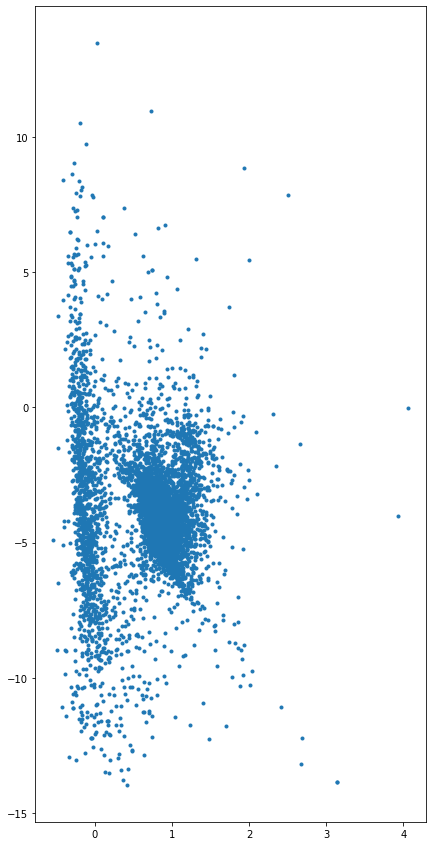

In [285]:
#print(xmm_gaia.columns)

uvw2=xmm_gaia['UVW2mAB']
uvm2=xmm_gaia['UVM2mAB']
uvw1=xmm_gaia['UVW1mAB']
u=xmm_gaia['UmAB']
b=xmm_gaia['BmAB']
v=xmm_gaia['VmAB']
bp=xmm_gaia['phot_bp_mean_mag']
rp=xmm_gaia['phot_rp_mean_mag']
dm=10-5*np.log10(xmm_gaia['parallax'])


fig, ax =plt.subplots(figsize=(7,15))
ax.plot(bp-rp,-(bp-dm),'.')
plt.show()

In [286]:
xmm_gaia_out='/home/mauro/xmm_gaia.csv'
xmm_gaia.write(xmm_gaia_out) #, format='ascii', overwrite=True)
